In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression


import torch
import torch.nn as nn
import torch.optim as optim

データの準備

In [3]:
df=pd.read_csv('../../data/learning_data.csv',index_col=0)
df.head()

,kmeans_dist,kmeans_cluster,dbscan_cluster,pca_1,pca_2,pca_3,pca_4,anomaly_score,nearest_cosine_similarity,dengue
0,0.875297,0.333333,0.000000,0.690117,0.530614,0.355845,0.178560,1.0,0.248749,1.0
1,0.909391,0.333333,0.000378,0.548990,0.361146,0.634171,0.669946,1.0,0.372575,0.0
2,0.795394,0.666667,0.000755,0.402503,0.733854,0.690624,0.451737,1.0,0.528842,0.0
3,0.937340,0.000000,0.001133,0.472950,0.346633,0.879878,0.674196,0.0,0.441506,0.0
4,0.832796,0.000000,0.001511,0.601353,0.324567,0.526282,0.702055,1.0,0.329382,1.0


In [4]:
X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

機械学習モデル

In [19]:
# サポートベクターマシン
svm=SVC(kernel="rbf",class_weight='balanced',probability=True)
svm.fit(X_train,y_train)

# ランダムフォレスト
rf_model = RandomForestClassifier(n_estimators=150, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

# XGBoost
xgb_model = XGBClassifier(n_estimators=150, max_depth=5, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

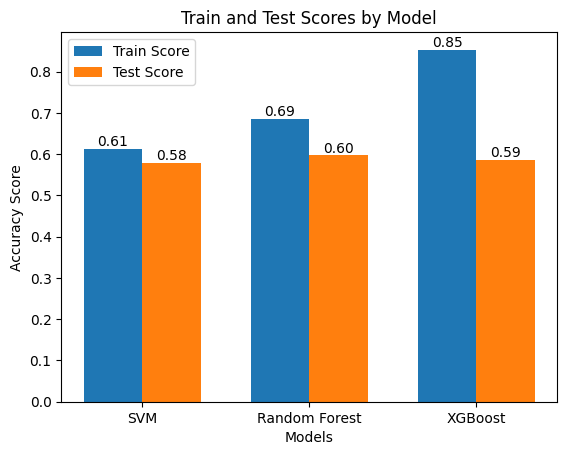

In [20]:
# モデルスコアの計算
svm_train_score = svm.score(X_train, y_train)
svm_test_score = svm.score(X_test, y_test)

rf_train_score = rf_model.score(X_train, y_train)
rf_test_score = rf_model.score(X_test, y_test)

xgb_train_score = xgb_model.score(X_train, y_train)
xgb_test_score = xgb_model.score(X_test, y_test)

# 棒グラフを作成
models = ['SVM', 'Random Forest', 'XGBoost']
train_scores = [svm_train_score, rf_train_score, xgb_train_score]
test_scores = [svm_test_score, rf_test_score, xgb_test_score]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots()
train_bars = ax.bar(x - width/2, train_scores, width, label='Train Score')
test_bars = ax.bar(x + width/2, test_scores, width, label='Test Score')

ax.set_xlabel('Models')
ax.set_ylabel('Accuracy Score')
ax.set_title('Train and Test Scores by Model')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# スコアを棒の上に表示
for bar in train_bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.2f}', ha='center', va='bottom')

for bar in test_bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.2f}', ha='center', va='bottom')

plt.show()

深層学習モデル

In [7]:
class DNN_1(nn.Module):
    def __init__(self, input_dim):
        super(DNN_1, self).__init__()
        self.layer1 = nn.Linear(input_dim, 1024)
        self.layer2 = nn.Linear(1024, 512)
        self.layer3 = nn.Linear(512, 256)
        self.layer4 = nn.Linear(256, 128)
        self.layer5 = nn.Linear(128, 64)
        self.layer6 = nn.Linear(64, 32)
       

        self.dropout = nn.Dropout(p=0.2)

        self.output_layer = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        
        x=torch.relu(self.layer2(x))
        x=self.dropout(x)

        x = torch.relu(self.layer3(x))
        
        x = torch.relu(self.layer4(x))
        x=self.dropout(x)
        x = torch.relu(self.layer5(x))
        
        x = torch.relu(self.layer6(x))

        
        x = torch.sigmoid(self.output_layer(x)) 
        return x

In [8]:
class DNN_2(nn.Module):
    def __init__(self, input_dim):
        super(DNN_2, self).__init__()
        self.layer1 = nn.Linear(input_dim, 1024)
        self.layer2 = nn.Linear(1024, 512)
        self.layer3 = nn.Linear(512, 256)
        self.layer4 = nn.Linear(256, 128)
        self.layer5 = nn.Linear(128, 64)
        self.layer6 = nn.Linear(64, 32)
       

        self.dropout = nn.Dropout(p=0.2)

        self.output_layer = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x=self.dropout(x)
        x=torch.relu(self.layer2(x))
        

        x = torch.relu(self.layer3(x))
        x=self.dropout(x)

        x = torch.relu(self.layer4(x))
        
        x = torch.relu(self.layer5(x))
        x=self.dropout(x)
        
        x = torch.relu(self.layer6(x))

        
        x = torch.sigmoid(self.output_layer(x)) 
        return x

In [9]:
class AttentionBinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(AttentionBinaryClassifier, self).__init__()
        
        # Attention層の重み
        self.attention_weights = nn.Parameter(torch.rand(input_dim))  
        
        # DNN層
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)

        self.dropout=nn.Dropout(0.2)

        self.output_layer = nn.Linear(32, 1)
        
    def forward(self, x):
        # Attentionの重み付け
        attention_scores = torch.sigmoid(self.attention_weights) 
        x = x * attention_scores  
        
        # DNNを通して分類
        x = torch.relu(self.fc1(x))
        
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)

        x = torch.relu(self.fc3(x))
        
        x = torch.sigmoid(self.output_layer(x)) 
        return x


In [10]:
# モデルの初期化
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X_train_tensor.shape[1]

DNN_1=DNN_1(input_dim=input_dim).to(device)
DNN_2=DNN_2(input_dim=input_dim).to(device)
Attention = AttentionBinaryClassifier(input_dim=input_dim).to(device)

# 損失関数と最適化
DNN_1_optim = optim.Adam(DNN_1.parameters(), lr=0.001)
DNN_2_optim = optim.Adagrad(DNN_2.parameters(), lr=0.001)
Attention_optim=optim.Adam(Attention.parameters(),lr=0.001)

models = [DNN_1, DNN_2,Attention ]
criterions = criterions = [
    nn.BCELoss(),  # DNN_1用
    nn.BCELoss(),  # DNN_2用
    nn.BCELoss()   # Attention用
]

optimizers = [DNN_1_optim,DNN_2_optim,Attention_optim]

Training model 1/3
Epoch [1/400], Loss: 0.6226
Epoch [2/400], Loss: 0.5617
Epoch [3/400], Loss: 0.5598
Epoch [4/400], Loss: 0.5600
Epoch [5/400], Loss: 0.5588
Epoch [6/400], Loss: 0.5623
Epoch [7/400], Loss: 0.5576
Epoch [8/400], Loss: 0.5579
Epoch [9/400], Loss: 0.5542
Epoch [10/400], Loss: 0.5535
Epoch [11/400], Loss: 0.5529
Epoch [12/400], Loss: 0.5539
Epoch [13/400], Loss: 0.5529
Epoch [14/400], Loss: 0.5530
Epoch [15/400], Loss: 0.5514
Epoch [16/400], Loss: 0.5500
Epoch [17/400], Loss: 0.5535
Epoch [18/400], Loss: 0.5523
Epoch [19/400], Loss: 0.5489
Epoch [20/400], Loss: 0.5491
Epoch [21/400], Loss: 0.5504
Epoch [22/400], Loss: 0.5494
Epoch [23/400], Loss: 0.5470
Epoch [24/400], Loss: 0.5467
Epoch [25/400], Loss: 0.5452
Epoch [26/400], Loss: 0.5453
Epoch [27/400], Loss: 0.5457
Epoch [28/400], Loss: 0.5472
Epoch [29/400], Loss: 0.5454
Epoch [30/400], Loss: 0.5482
Epoch [31/400], Loss: 0.5471
Epoch [32/400], Loss: 0.5470
Epoch [33/400], Loss: 0.5457
Epoch [34/400], Loss: 0.5454
Epoc

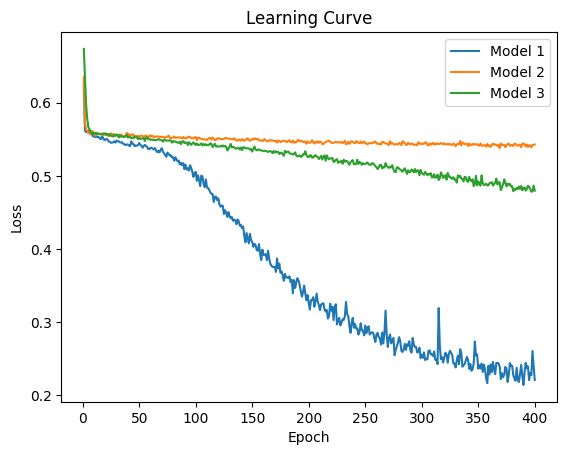

In [11]:
num_epochs = 400
batch_size = 128
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

train_losses_per_model = [] 

for model_idx, (model, criterion, optimizer) in enumerate(zip(models, criterions, optimizers)):
    model.train()
    train_losses = []  # 現在のモデルの損失を記録
    print(f"Training model {model_idx + 1}/{len(models)}")
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    train_losses_per_model.append(train_losses)

# 学習曲線
for model_idx, losses in enumerate(train_losses_per_model):
    plt.plot(range(1, num_epochs + 1), losses, label=f'Model {model_idx + 1}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()



--- Evaluating Model 1 ---

Accuracy: 59.23%
Precision: 0.4741
Recall: 0.5133
F1 Score: 0.4929
Matthews Correlation Coefficient: 0.1532
Specificity: 0.6419


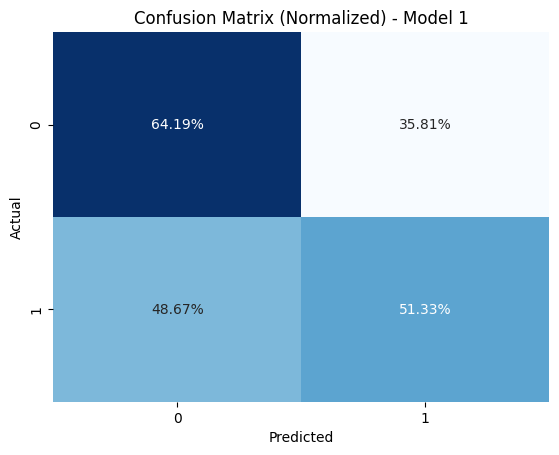

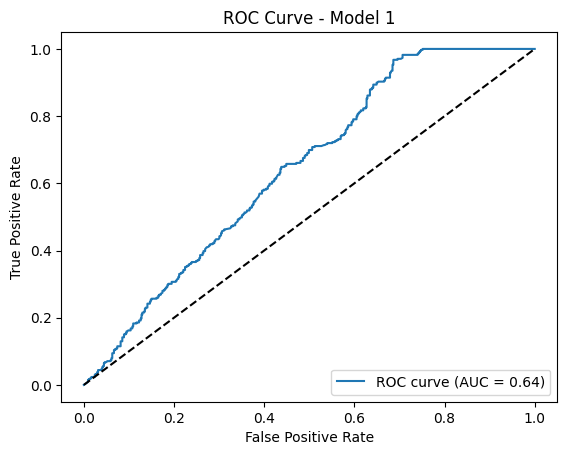

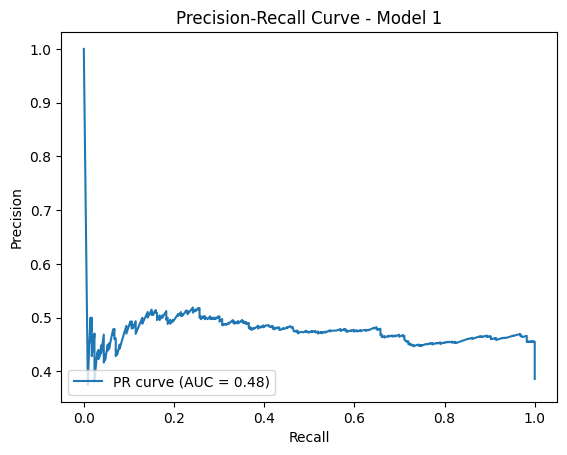


--- Evaluating Model 2 ---

Accuracy: 59.11%
Precision: 0.4812
Recall: 0.7552
F1 Score: 0.5878
Matthews Correlation Coefficient: 0.2422
Specificity: 0.4879


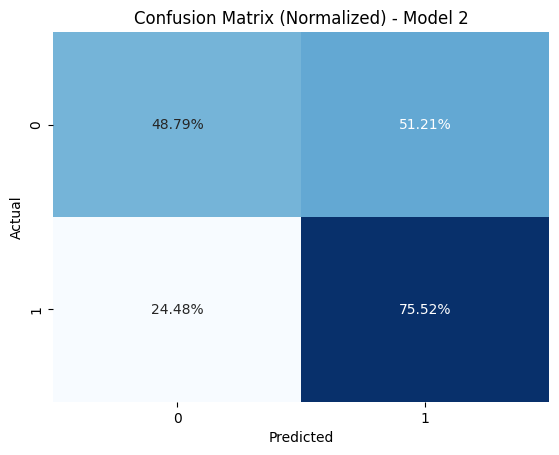

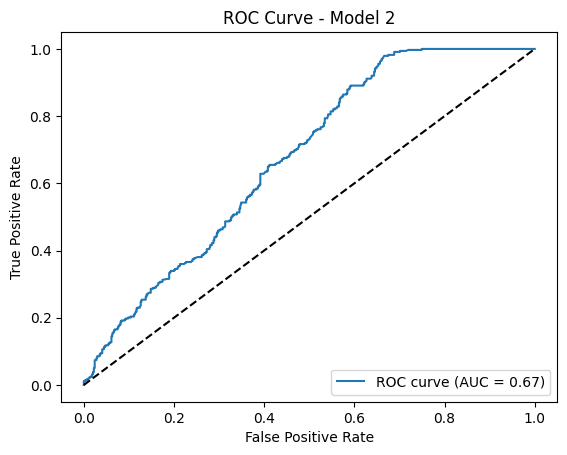

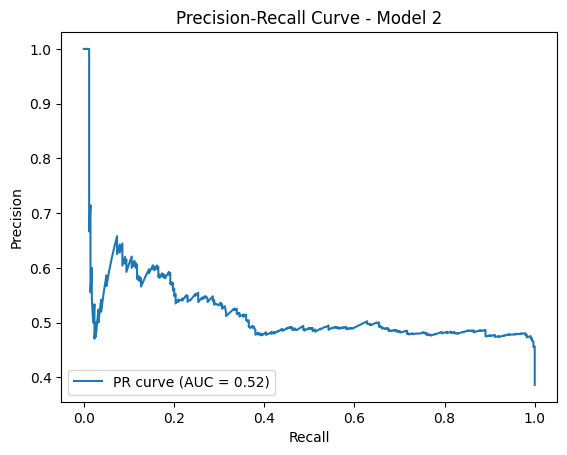


--- Evaluating Model 3 ---

Accuracy: 58.09%
Precision: 0.4645
Recall: 0.5605
F1 Score: 0.5080
Matthews Correlation Coefficient: 0.1505
Specificity: 0.5937


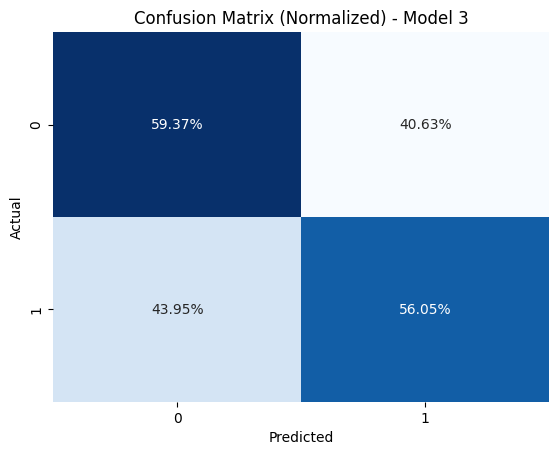

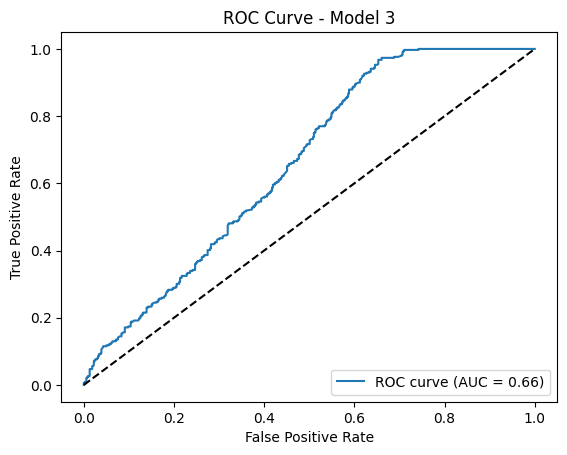

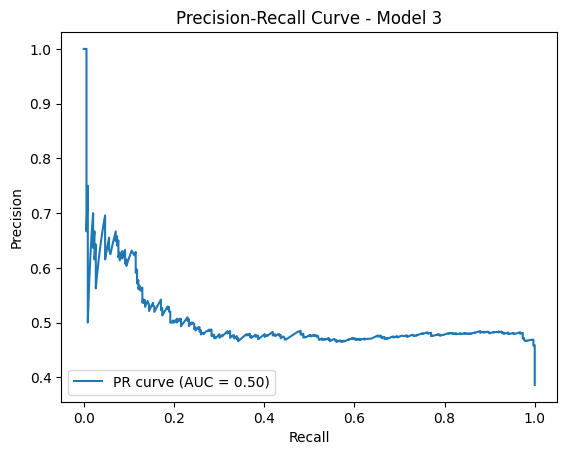

In [12]:
# 評価を各モデルで実施
for idx, model in enumerate(models):
    print(f"\n--- Evaluating Model {idx + 1} ---\n")
    
    model.eval()
    with torch.no_grad():
        X_test_tensor = X_test_tensor.to(device)
        y_test_tensor = y_test_tensor.to(device)

        # 予測と確率
        test_outputs = model(X_test_tensor).squeeze()
        predictions = (test_outputs > 0.49).float()
        y_true = y_test_tensor.cpu().numpy()
        y_pred = predictions.cpu().numpy()
        y_prob = test_outputs.cpu().numpy()

        # 評価指標
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        mcc = matthews_corrcoef(y_true, y_pred)
        specificity = recall_score(y_true, y_pred, pos_label=0)  
        print(f'Accuracy: {accuracy * 100:.2f}%')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1 Score: {f1:.4f}')
        print(f'Matthews Correlation Coefficient: {mcc:.4f}')
        print(f'Specificity: {specificity:.4f}')

        # 混同行列（割合表示）
        cm = confusion_matrix(y_true, y_pred, normalize='true')
        sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix (Normalized) - Model {idx + 1}")
        plt.show()

        # ROC曲線とAUC
        fpr, tpr, thresholds = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--') 
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Model {idx + 1}')
        plt.legend(loc="lower right")
        plt.show()

        # Precision-Recall曲線
        precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
        pr_auc = auc(recall_curve, precision_curve)
        plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve - Model {idx + 1}')
        plt.legend(loc="lower left")
        plt.show()

In [14]:
# 学習用スタッキングデータ
svm_preds=svm.predict_proba(X_train)
rf_preds = rf_model.predict_proba(X_train)[:, 1]
xgb_preds = xgb_model.predict_proba(X_train)[:, 1]


DNN1_preds = DNN_1(X_train_tensor.to(device)).cpu().detach().numpy().squeeze()
DNN2_preds = DNN_2(X_train_tensor.to(device)).cpu().detach().numpy().squeeze()
Attention_preds = Attention(X_train_tensor.to(device)).cpu().detach().numpy().squeeze()

train_stacked_features = np.column_stack((svm_preds,rf_preds, xgb_preds, DNN1_preds, DNN2_preds, Attention_preds))
train_stacked_labels=y_train

# テスト用スタッキングデータ
svm_preds=svm.predict_proba(X_test)
rf_preds = rf_model.predict_proba(X_test)[:, 1]
xgb_preds = xgb_model.predict_proba(X_test)[:, 1]

DNN1_preds = DNN_1(X_test_tensor.to(device)).cpu().detach().numpy().squeeze()
DNN2_preds = DNN_2(X_test_tensor.to(device)).cpu().detach().numpy().squeeze()
Attention_preds = Attention(X_test_tensor.to(device)).cpu().detach().numpy().squeeze()

test_stacked_features = np.column_stack((svm_preds,rf_preds, xgb_preds, DNN1_preds, DNN2_preds, Attention_preds))
test_stacked_labels=y_test




In [15]:
meta_model = LogisticRegression(random_state=42)
meta_model.fit(train_stacked_features, train_stacked_labels)


LogisticRegression(random_state=42)

Accuracy: 57.40%
Precision: 0.4496
Recall: 0.4602
F1 Score: 0.4548
Matthews Correlation Coefficient: 0.1054
Specificity: 0.6456
AUC Score: 0.6301


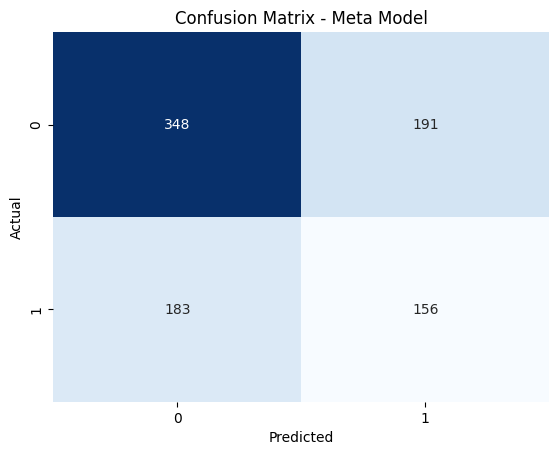

In [16]:
# メタモデルの評価
stack_val_preds = meta_model.predict_proba(test_stacked_features)[:, 1]
stack_val_predictions = (stack_val_preds > 0.49).astype(int)

# 評価指標の計算
accuracy = accuracy_score(test_stacked_labels, stack_val_predictions)
precision = precision_score(test_stacked_labels, stack_val_predictions)
recall = recall_score(test_stacked_labels, stack_val_predictions)
f1 = f1_score(test_stacked_labels, stack_val_predictions)
mcc = matthews_corrcoef(test_stacked_labels, stack_val_predictions)
specificity = recall_score(test_stacked_labels, stack_val_predictions, pos_label=0)
auc_score = roc_auc_score(test_stacked_labels, stack_val_preds)

# 結果を出力
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Matthews Correlation Coefficient: {mcc:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f"AUC Score: {auc_score:.4f}")

# スタッキングモデルの混同行列表示
stack_cm = confusion_matrix(test_stacked_labels, stack_val_predictions)
sns.heatmap(stack_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Meta Model")
plt.show()
